<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/hand_representation_latent_EEG/CAS_project_Giedrius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decoding Hand Movements from Latent EEG Representations

Name: Giedrius Mirklys

Student #: s1101773

`Data processing and model architecture are inspired by https://www.kaggle.com/code/aarajbhattarai/gesture-recognition`


# Install the required packages

In [1]:
%pip install nvidia-cudnn-cu12
%pip install --upgrade flax jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
  Attempting uninstall: flax
    Found existing installation: flax 0.8.5
    Uninstalling flax-0.8.5:
      Successfully uninstalled flax-0.8.5


# Connect to Google Drive

In [ ]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_PATH = "/content/drive/MyDrive/Projects/neural encodings"

# Import the packages

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

import torch as th

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import glorot_uniform
import orbax.checkpoint as ocp

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


from zipfile import ZipFile

In [ ]:
jax.config.update('jax_platform_name', 'gpu')

# Process and visualize data

In [ ]:
# %%time
# FILE_PATH = ROOT_PATH + "/data"
# list_dir = os.listdir(FILE_PATH)

# # for zipfile in list_dir:
#     if zipfile.endswith(".zip"):  # Only process zip files
#         with ZipFile(os.path.join(FILE_PATH, zipfile), "r") as z:
#             z.extractall(path=FILE_PATH)  # Specify extraction path
#             for filename in z.namelist():
#                 if filename.endswith(".zip"):
#                     print(f"Extracted: {filename}")
#                     with ZipFile(os.path.join(FILE_PATH, filename), "r") as inner_zip:
#                         inner_zip.extractall(path=FILE_PATH)
#                         print(f"Extracted: {filename}")

In [ ]:
TRAIN_PATH = f"{ROOT_PATH}/data/train"
TEST_PATH = f"{ROOT_PATH}/data/test"

In [ ]:
def read_csv(data_path, events_path):
    data = pd.read_csv(data_path)
    events = pd.read_csv(events_path)

    data = data.iloc[:, 1:].values  # removes the id column
    events = events.iloc[:, 1:].values  # removes the id column

    return data, events

In [ ]:
eeg_signals = []
gestures = []
data_files = [p for p in os.listdir(TRAIN_PATH) if p.endswith("data.csv")]

for data_file in tqdm(data_files):
    id = data_file.split(".")[0].replace("_data", "")
    event_file = f"{id}_events.csv"

    data_file_path = os.path.join(TRAIN_PATH, data_file)
    events_file_path = os.path.join(TRAIN_PATH, event_file)

    data, events = read_csv(data_file_path, events_file_path)

    eeg_signals.append(data.T.astype(np.float32))
    gestures.append(events.T.astype(np.float32))

100%|██████████| 85/85 [01:43<00:00,  1.21s/it]


In [ ]:
threshold = 0.01

In [ ]:
electrode_map = {
    "Fp1": 0,
    "Fp2": 1,
    "F7": 2,
    "F3": 3,
    "Fz": 4,
    "F4": 5,
    "F8": 6,
    "FC5": 7,
    "FC1": 8,
    "FC2": 9,
    "FC6": 10,
    "T7": 11,
    "C3": 12,
    "Cz": 13,
    "C4": 14,
    "T8": 15,
    "TP9": 16,
    "CP5": 17,
    "CP1": 18,
    "CP2": 19,
    "CP6": 20,
    "TP10": 21,
    "P7": 22,
    "P3": 23,
    "Pz": 24,
    "P4": 25,
    "P8": 26,
    "PO9": 27,
    "O1": 28,
    "Oz": 29,
    "O2": 30,
    "PO10": 31,
}

In [ ]:
class EEGSignalDataset(Dataset):
    def __init__(
        self,
        data,
        gestures,
        chunk_size=2**9, # .5 s chunks
        in_len=2**9, # one hand movement per .5 s chunk
    ):
        self.data = data
        self.gestures = gestures
        self.eps = 1e-7
        self.in_len = in_len
        self.remove_channels = []

        self.index = [
            (i, start, end)
            for i, gesture_indices in enumerate(
                self.__get_sample_indices(gestures, chunk_size)
            )
            for start, end in gesture_indices
        ]

        _data = np.concatenate(self.data, axis=1)
        mean = np.mean(_data, axis=1)
        mean = np.reshape(mean, (mean.shape[0], 1))

        std = np.std(_data, axis=1)
        std = np.reshape(std, (std.shape[0], 1))

        for dt in self.data:
            dt -= mean
            dt /= std + self.eps

    def __get_sample_indices(self, gestures, chunk_size, threshold=0.01):
        """
        Get the start and end indices of signal chunks where the activation is above the threshold.
        """
        sample_indices = []
        for gesture in gestures:
            gesture_indices = []
            num_chunks = gesture.shape[1] // chunk_size + (
                1 if gesture.shape[1] % chunk_size != 0 else 0
            )
            for j in range(num_chunks):
                start_idx = j * chunk_size
                end_idx = min(gesture.shape[1], (j + 1) * chunk_size)
                chunk_mean = np.mean(gesture[:, start_idx:end_idx])
                if chunk_mean >= threshold:
                    gesture_indices.append((start_idx, end_idx))  # Tuple of two values
            sample_indices.append(gesture_indices)
        return sample_indices

    def __getitem__(self, idx):
        i, start, end = self.index[idx]
        raw_data = np.array(self.data[i])[:, start:end] # Shape: (32, sequence_length)
        label = np.array(self.gestures[i])[:, start:end]  # Shape: (6, sequence_length)
        label = np.argmax(label.sum(axis=1))  # getting the most prominent hand movement
        pad = self.in_len - raw_data.shape[1]
        if pad > 0:
            raw_data = np.pad(
                raw_data, ((0, 0), (0, pad)), "constant", constant_values=0
            )

        if self.remove_channels:
            electrode_indices = [electrode_map[channel] for channel in self.remove_channels]

            raw_data[electrode_indices, :] = .0

        # Transpose raw_data to shape: (sequence_length, channels)
        raw_data = raw_data.T  # Shape: (sequence_length, 32)

        # Convert to tensors
        raw_data = th.from_numpy(raw_data.astype(np.float32))

        # One-hot encode the label
        one_hot_label = np.zeros(6)
        one_hot_label[label] = 1
        one_hot_label = th.from_numpy(one_hot_label.astype(np.float32))

        return raw_data, one_hot_label

    def add_remove_channels(self, channels):
        self.remove_channels = channels
    def __len__(self):
        return len(self.index)

In [ ]:
train_eeg = eeg_signals[:-2]
train_gestures = gestures[:-2]

valid_eeg = eeg_signals[-2:]
valid_gestures = gestures[-2:]

# Build Encoder-Decoder

In [ ]:
class Encoder(nn.Module):
    in_channels: int
    hidden_channels: int

    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Conv(features=self.in_channels, kernel_size=(5,), padding=((2, 2),))(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        # 2nd Conv1d: Kernel size 16, stride 16
        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(16,),
            strides=(16,),
            padding="VALID",
            kernel_init=glorot_uniform()
        )(x)

        # LeakyReLU with negative slope 0.1
        x = nn.leaky_relu(x, negative_slope=0.1)

        # 3rd Conv1d: Kernel size 7, padding 3
        x = nn.Conv(features=self.hidden_channels,
                    kernel_size=(7,),
                    padding=((3, 3),),
                    kernel_init=glorot_uniform()
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        # Repeat blocks without changing sequence length
        for _ in range(2):
            x = self.__block(x, training)
        return x

    def __block(self, x, training):
        x = nn.max_pool(x, window_shape=(2,), strides=(2,))

        # Dropout with rate 0.1
        x = nn.Dropout(rate=0.1)(
            x, deterministic=not training
        )

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(5,),
            padding=((2, 2),),
            kernel_init=glorot_uniform()
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)

        x = nn.Conv(
            features=self.hidden_channels,
            kernel_size=(5,),
            padding=((2, 2),),
            kernel_init=glorot_uniform()
        )(x)
        x = nn.leaky_relu(x, negative_slope=0.1)
        return x

In [ ]:
class Decoder(nn.Module):
    out_channels: int
    hidden_channels: int
    @nn.compact
    def __call__(self, x):
        # Global average pooling over time dimension
        x = jnp.mean(x, axis=1)  # Shape: (batch, hidden_channels)
        # Fully connected layer to predict hand movement
        x = nn.Dense(features=self.hidden_channels,
                    kernel_init=glorot_uniform())(x)
        x = nn.Dense(features=self.out_channels,
                    kernel_init=glorot_uniform())(x)  # Shape: (batch, movements)
        # x = nn.softmax(x)  # Apply softmax for classification
        return x


In [ ]:
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (1, 1024, 32))

encoder = Encoder(in_channels=32, hidden_channels=32)
encoder_params = encoder.init(key, x)

# Generate PRNG key for dropout
key, dropout_key = jax.random.split(key)
# Forward pass (training mode)
encoded = encoder.apply(encoder_params, x, rngs={"dropout": dropout_key})


decoder = Decoder(out_channels=6, hidden_channels=32)
decoder_params = decoder.init(key, encoded)

# Define the optimizer
learning_rate = 0.001
optimizer = optax.adamw(learning_rate=learning_rate, b1=0.5, b2=0.99)

params = {"encoder": encoder_params, "decoder": decoder_params}

state = train_state.TrainState.create(apply_fn=None, params=params, tx=optimizer)

# Train the model

In [ ]:
def compute_loss(predictions, labels):
    num_classes = labels.shape[-1]
    loss = optax.softmax_cross_entropy(predictions, labels)
    return jnp.mean(loss)

In [ ]:
@jax.jit
def train_step(state, batch, key):
    key, dropout_key = jax.random.split(key)
    def loss_fn(params):
        raw_data, label = batch
        encoded = encoder.apply(params["encoder"], raw_data, rngs={"dropout": dropout_key})
        predictions = decoder.apply(params["decoder"], encoded)
        return compute_loss(predictions, label)

    grads = jax.grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, key

In [ ]:
def compute_accuracy(predictions, labels):
    if labels.ndim == 2:
        labels = np.argmax(labels, axis=1)

    predicted_classes = np.argmax(predictions, axis=1)

    correct_predictions = np.sum(predicted_classes == labels)

    accuracy = correct_predictions / labels.shape[0]
    return accuracy



In [ ]:
# Training loop
num_epochs = 45
batch_size = 64
epoch_losses = []
epoch_accuracies = []
global_step = 0 # for saving the model

In [ ]:
# Create the dataset and dataloader
dataset = EEGSignalDataset(train_eeg, train_gestures)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
raw_data, label = batch

In [ ]:
raw_data.shape, label.shape

(torch.Size([64, 512, 32]), torch.Size([64, 6]))

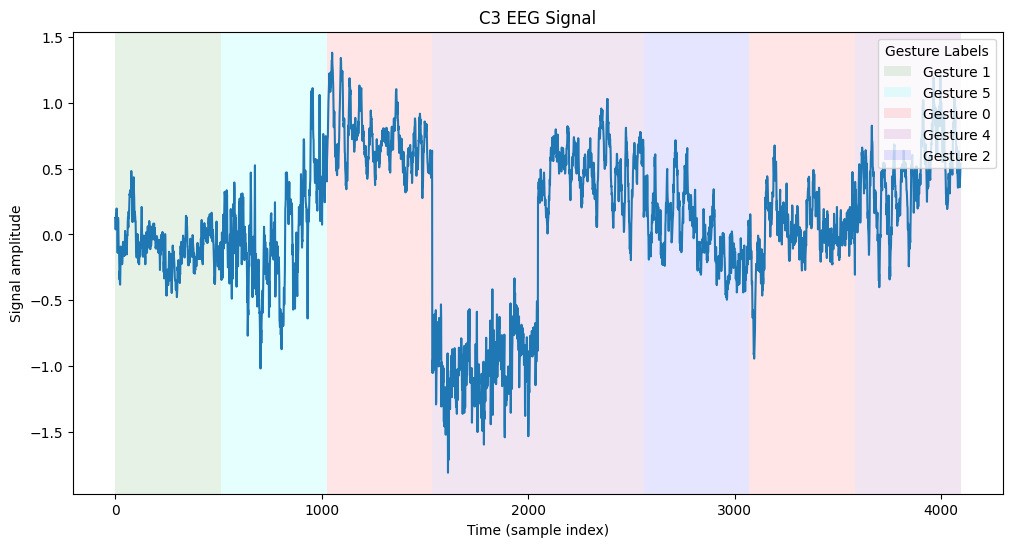

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from collections import OrderedDict

# 1. Concatenate the signals: shape becomes [64 * 512, 32]
X_concat = raw_data[:8, :].view(-1, 32)  # Flatten batch*chunk_size

# 2. Get the gesture labels for each chunk
#   e.g., if y is one-hot, gesture[i] = torch.argmax(y[i])
gestures = th.argmax(label[:8, :], dim=1)  # Shape [batch_size]

# 3. Plot each channel over the concatenated time axis
#    We'll plot just one or a few channels for demonstration
time_axis = np.arange(X_concat.shape[0])

fig, ax = plt.subplots(figsize=(12, 6))

channel_idx = 12  # pick one channel to plot, or loop over multiple
ax.plot(time_axis, X_concat[:, channel_idx].numpy())

# 4. Color-coded rectangles for each chunk
chunk_length = 512
y_min, y_max = ax.get_ylim()
rectangle_height = y_max - y_min

# Define a simple colormap for up to 6 gestures
colors = ["red", "green", "blue", "orange", "purple", "cyan"]
gesture_labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
handles = OrderedDict()

for i in range(8):
    gesture_label = gestures[i].item()
    rect_x = i * chunk_length

    # Add a semi-transparent rectangle with label
    rect = Rectangle(
        (rect_x, y_min),
        chunk_length,
        rectangle_height,
        facecolor=colors[gesture_label],
        alpha=0.1,
        label=gesture_labels[gesture_label]
    )
    ax.add_patch(rect)

    # Store unique labels and handles for the legend
    if gesture_labels[gesture_label] not in handles:
        handles[gesture_labels[gesture_label]] = rect


# Add a legend with unique labels
ax.legend(handles.values(), handles.keys(), title="Gesture Labels", loc="upper right")




ax.set_xlabel("Time (sample index)")
ax.set_ylabel("Signal amplitude")
ax.set_title("C3 EEG Signal")
plt.show()

In [ ]:
checkpoint_dir = os.path.join(ROOT_PATH, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
checkpointer = ocp.PyTreeCheckpointer()
options = ocp.CheckpointManagerOptions(save_interval_steps=100)
mngr = ocp.CheckpointManager(
    checkpoint_dir,
    checkpointers={'model': checkpointer},
    options=options)

In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = 0

    for batch in tqdm(dataloader):
        raw_data, label = batch
        raw_data = jnp.array(raw_data.numpy())
        label = jnp.array(label.numpy())

        state, key = train_step(state, (raw_data, label), key)

        global_step += 1

        mngr.save(global_step, {'model': state})

        encoder_params = state.params["encoder"]
        decoder_params = state.params["decoder"]

        key, dropout_key = jax.random.split(key)

        encoded = encoder.apply(encoder_params, raw_data, training=False, rngs={"dropout": dropout_key})
        predictions = decoder.apply(decoder_params, encoded)


        loss = compute_loss(predictions, label)
        accuracy = compute_accuracy(predictions, label)

        epoch_loss += loss
        epoch_accuracy += accuracy
        num_batches += 1

    epoch_loss /= num_batches
    epoch_accuracy /= num_batches
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    print(
        f"Epoch {epoch + 1} completed - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}"
    )

100%|██████████| 167/167 [01:20<00:00,  2.08it/s]


Epoch 1 completed - Loss: 1.4239, Accuracy: 0.4270


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch 2 completed - Loss: 1.1789, Accuracy: 0.5433


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 3 completed - Loss: 1.0759, Accuracy: 0.5922


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 4 completed - Loss: 1.0081, Accuracy: 0.6217


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch 5 completed - Loss: 0.9537, Accuracy: 0.6463


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 6 completed - Loss: 0.9039, Accuracy: 0.6636


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 7 completed - Loss: 0.8603, Accuracy: 0.6787


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 8 completed - Loss: 0.8263, Accuracy: 0.6943


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch 9 completed - Loss: 0.7819, Accuracy: 0.7101


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 10 completed - Loss: 0.7608, Accuracy: 0.7223


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 11 completed - Loss: 0.7258, Accuracy: 0.7298


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 12 completed - Loss: 0.7022, Accuracy: 0.7448


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 13 completed - Loss: 0.6776, Accuracy: 0.7544


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 14 completed - Loss: 0.6581, Accuracy: 0.7608


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 15 completed - Loss: 0.6333, Accuracy: 0.7717


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 16 completed - Loss: 0.6180, Accuracy: 0.7776


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 17 completed - Loss: 0.5980, Accuracy: 0.7861


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 18 completed - Loss: 0.5819, Accuracy: 0.7907


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 19 completed - Loss: 0.5633, Accuracy: 0.8001


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 20 completed - Loss: 0.5449, Accuracy: 0.8089


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 21 completed - Loss: 0.5351, Accuracy: 0.8112


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 22 completed - Loss: 0.5259, Accuracy: 0.8131


100%|██████████| 167/167 [01:09<00:00,  2.42it/s]


Epoch 23 completed - Loss: 0.5052, Accuracy: 0.8240


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 24 completed - Loss: 0.4931, Accuracy: 0.8306


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 25 completed - Loss: 0.4803, Accuracy: 0.8312


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 26 completed - Loss: 0.4656, Accuracy: 0.8361


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 27 completed - Loss: 0.4549, Accuracy: 0.8442


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 28 completed - Loss: 0.4406, Accuracy: 0.8497


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 29 completed - Loss: 0.4304, Accuracy: 0.8525


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 30 completed - Loss: 0.4147, Accuracy: 0.8542


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 31 completed - Loss: 0.4047, Accuracy: 0.8609


100%|██████████| 167/167 [01:08<00:00,  2.42it/s]


Epoch 32 completed - Loss: 0.3926, Accuracy: 0.8668


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 33 completed - Loss: 0.3848, Accuracy: 0.8696


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 34 completed - Loss: 0.3712, Accuracy: 0.8763


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 35 completed - Loss: 0.3548, Accuracy: 0.8840


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 36 completed - Loss: 0.3561, Accuracy: 0.8816


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 37 completed - Loss: 0.3365, Accuracy: 0.8903


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 38 completed - Loss: 0.3357, Accuracy: 0.8892


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 39 completed - Loss: 0.3206, Accuracy: 0.8977


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 40 completed - Loss: 0.3167, Accuracy: 0.9010


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]


Epoch 41 completed - Loss: 0.2980, Accuracy: 0.9032


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 42 completed - Loss: 0.2963, Accuracy: 0.9039


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 43 completed - Loss: 0.2898, Accuracy: 0.9087


100%|██████████| 167/167 [01:08<00:00,  2.44it/s]


Epoch 44 completed - Loss: 0.2769, Accuracy: 0.9129


100%|██████████| 167/167 [01:08<00:00,  2.43it/s]

Epoch 45 completed - Loss: 0.2745, Accuracy: 0.9159


In [ ]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-paper')

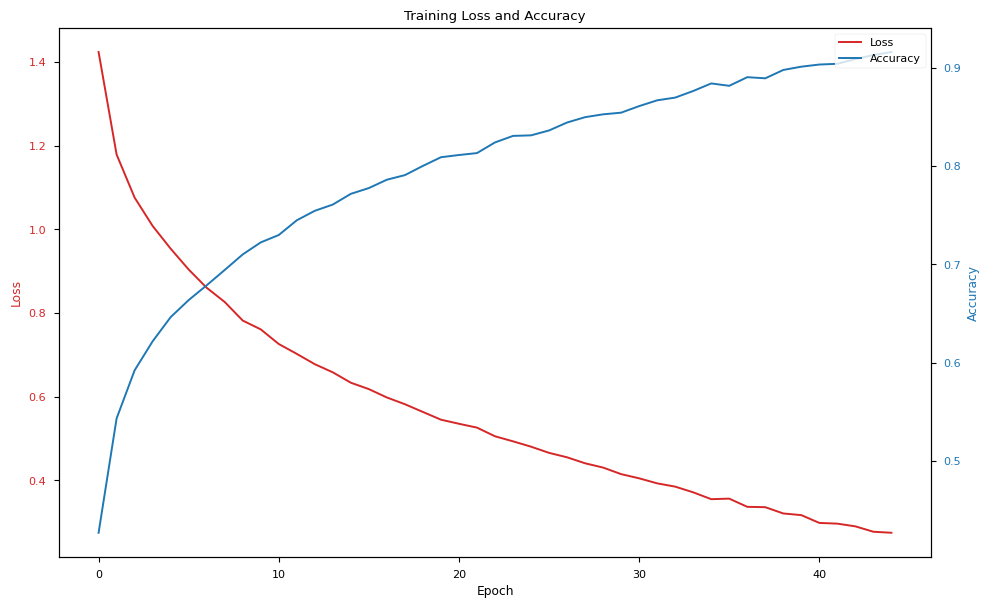

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epoch_losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epoch_accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Accuracy')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes) # Adjust legend position if needed
plt.show()

# Test the model

In [ ]:
# Create the validation dataset and dataloader
valid_dataset = EEGSignalDataset(valid_eeg, valid_gestures)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define the test_step function
@jax.jit
def test_step(state, batch):
    raw_data, label = batch
    encoded = encoder.apply(state.params["encoder"], raw_data, training=False)
    predictions = decoder.apply(state.params["decoder"], encoded)
    return predictions, label

# Evaluation loop for validation
def evaluate_model(state, valid_dataloader):
    total_loss = 0
    total_accuracy = 0
    num_batches = 0

    for batch in valid_dataloader:
        raw_data, label = batch
        raw_data = jnp.array(raw_data.numpy())  # Convert to JAX arrays
        label = jnp.array(label.numpy())

        predictions, true_labels = test_step(state, (raw_data, label))
        loss = compute_loss(predictions, true_labels)
        accuracy = compute_accuracy(predictions, true_labels)

        total_loss += loss
        total_accuracy += accuracy
        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    return avg_loss, avg_accuracy


In [ ]:
checkpoints = os.listdir(checkpoint_dir)
checkpoints = [int(checkpoint) for checkpoint in checkpoints]

In [ ]:
valid_accuracy = []
valid_loss = []
states = []

# select the best model
for checkpoint in tqdm(checkpoints):

    _restored = mngr.restore(step=checkpoint)
    _restored_params = _restored['model']["params"]
    _restored_state = state.replace(params=_restored_params)

    _loss, _accuracy = evaluate_model(_restored_state, valid_dataloader)
    valid_loss.append(_loss)
    valid_accuracy.append(_accuracy)
    states.append(_restored_state)

    del _restored_state

  0%|          | 0/76 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
  1%|▏         | 1/76 [00:02<03:35,  2.87s/it]/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
100%|██████████| 76/76 [01:57<00:00,  1.55s/it]


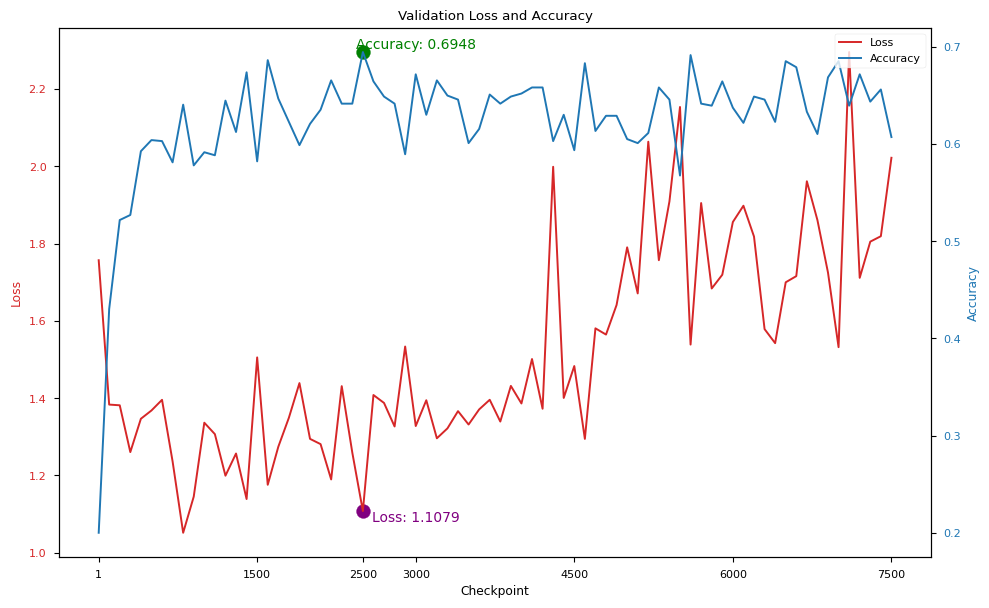

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Checkpoint')
ax1.set_ylabel('Loss', color=color)
ax1.plot(checkpoints, valid_loss, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)

ax2.plot(checkpoints, valid_accuracy, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Find the point with the highest accuracy
max_accuracy_index = np.argmax(valid_accuracy)
max_accuracy = valid_accuracy[max_accuracy_index]
corresponding_loss = valid_loss[max_accuracy_index]

# Mark the point with the highest accuracy
ax2.scatter(checkpoints[max_accuracy_index], max_accuracy, color='green', marker='o', s=100)
ax1.scatter(checkpoints[max_accuracy_index], corresponding_loss, color='purple', marker='o', s=100)


# Add labels with the values
ax2.text(checkpoints[max_accuracy_index]+500, max_accuracy, f"Accuracy: {max_accuracy:.4f}", ha='center', va='bottom', color='green')
ax1.text(checkpoints[max_accuracy_index]+500, corresponding_loss, f"Loss: {corresponding_loss:.4f}", ha='center', va='top', color='purple')

# Improve x-axis notation
ax1.set_xticks(sorted(checkpoints[::15] + [checkpoints[max_accuracy_index]]))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Validation Loss and Accuracy')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes) # Adjust legend position if needed
plt.show()

# Test the model with reduced data

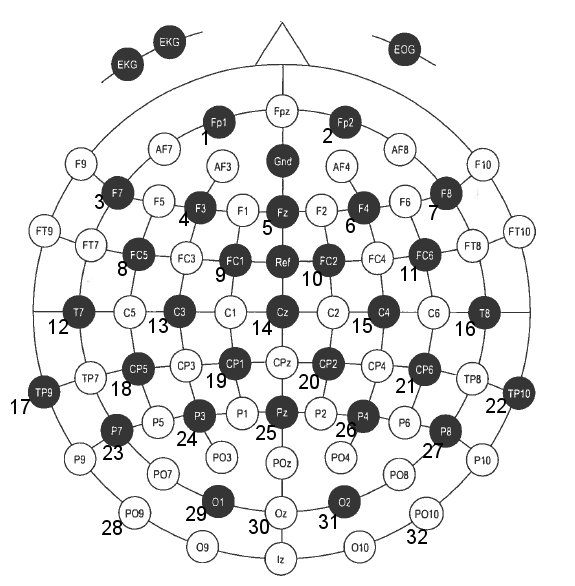

Main locations for the right hand: C3, FC1, FC5, CP1, and CP5.

In [ ]:
channels_to_null = {
    "furthest points": ["TP9", "PO9", "PO10", "TP10", "O1", "O2"], #6
    "right hemisphere": ["P4", "P8", "CP2", "CP6", "C4", "T8", "FC2", "FC6", "F4", "F8", "Fp2"], # 11
    "remaining": ["Fp1", "F3", "Fz", "Cz", "Pz", "P3", "P7", "T7", "F7", "F3"], # 10
    "hand": ["FC1", "FC5", "CP1", "CP5", "C3"], # 5
}

In [ ]:
import pandas as pd
from collections import defaultdict

test_table = defaultdict(list)

In [ ]:
restored_state = states[max_accuracy_index]

loss, accuracy = evaluate_model(restored_state, valid_dataloader)

test_table["num_nulled_channels"].append(0)
test_table["loss"].append(loss)
test_table["accuracy"].append(accuracy)
test_table["nulled_channels"].append([])
test_table["added_channel"].append(None)

In [ ]:
combined_channels = []

for location, channels_to_null_set in channels_to_null.items():
    print(f"{location}: ")
    for channel in tqdm(channels_to_null_set):
        # Create a copy of combined_channels
        current_channels = combined_channels + [channel]
        valid_dataset.add_remove_channels(current_channels)

        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

        loss, accuracy = evaluate_model(restored_state, valid_dataloader)

        test_table["num_nulled_channels"].append(len(current_channels))
        test_table["loss"].append(loss)
        test_table["accuracy"].append(accuracy)
        test_table["nulled_channels"].append(current_channels)
        test_table["added_channel"].append(channel)

        # Append to the original list for the next iteration
        combined_channels.append(channel)

furthest points: 


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


right hemisphere: 


100%|██████████| 11/11 [00:15<00:00,  1.40s/it]


remaining: 


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


hand: 


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


In [ ]:
test_table_pd = pd.DataFrame(test_table)

In [ ]:
segments = [6, 17, 27, 32]

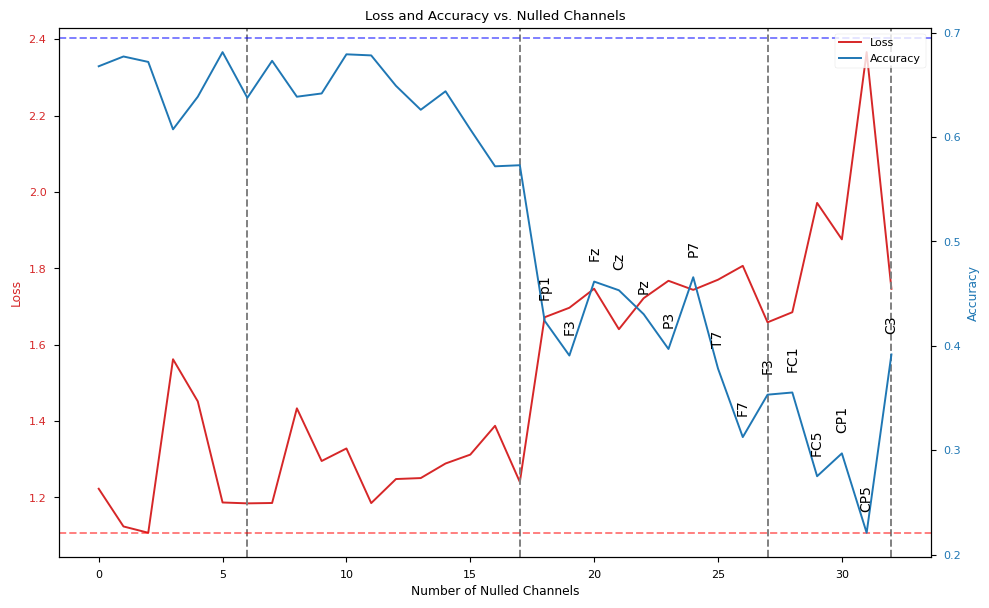

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Extract data from the table
num_nulled_channels = test_table["num_nulled_channels"]
losses = test_table["loss"]
accuracies = test_table["accuracy"]
added_channels = test_table["added_channel"]

# Plot Loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Number of Nulled Channels')
ax1.set_ylabel('Loss', color=color)
ax1.plot(num_nulled_channels, losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(num_nulled_channels, accuracies, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Add labels for the added channel
for i, channel in enumerate(added_channels):
    if channel is not None and i > segments[-3]:
        ax2.text(num_nulled_channels[i], accuracies[i]+0.02, channel, ha='center', va='bottom', rotation=90)

for location in segments:
    ax1.axvline(x=location, color='gray', linestyle='--')

ax2.axhline(y=max_accuracy, color='blue', linestyle='--', alpha=0.5)
ax1.axhline(y=corresponding_loss, color='red', linestyle='--', alpha=0.5)



plt.tight_layout()

plt.title('Loss and Accuracy vs. Nulled Channels')
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()

# Build an SVM classifier

In [ ]:
X, y = [], []

for raw_data, label in tqdm(dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(restored_state.params["encoder"], raw_data.numpy(), training=False)
    # encoded_data = encoded_data.reshape(encoded_data.shape[0], -1)
    X.extend(encoded_data.reshape(encoded_data.shape[0], -1))  # Flatten and extend encoded data
    y.extend(np.argmax(label.numpy(), axis=1)) # Get the label index along the class axis

100%|██████████| 167/167 [01:07<00:00,  2.46it/s]


In [ ]:
len(X[-1]), len(x[-2])

(256, 1024)

In [ ]:
X = np.array(X[:-1])
y = np.array(y[:-1])

In [ ]:
X.shape, y.shape

((10673, 256), (10673,))

In [ ]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X, y)

SVC(kernel='linear')

In [ ]:
y_pred = svm_classifier.predict(X)

In [ ]:
accuracy = accuracy_score(y, y_pred)
print(f"SVM Accuracy: {accuracy}")

SVM Accuracy: 0.7794434554483276


In [ ]:
valid_dataset = EEGSignalDataset(valid_eeg, valid_gestures)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_X, valid_y = [], []

for raw_data, label in tqdm(valid_dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(restored_state.params["encoder"], raw_data.numpy(), training=False)
    # encoded_data = encoded_data.reshape(encoded_data.shape[0], -1)
    valid_X.extend(encoded_data.reshape(encoded_data.shape[0], -1))  # Flatten and extend encoded data
    valid_y.extend(np.argmax(label.numpy(), axis=1)) # Get the label index along the class axis


100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


In [ ]:
valid_X = np.array(valid_X[:-1])
valid_y = np.array(valid_y[:-1])

In [ ]:
valid_y_pred = svm_classifier.predict(valid_X)

In [ ]:
accuracy = accuracy_score(valid_y, valid_y_pred)
print(f"SVM Accuracy: {accuracy}")

SVM Accuracy: 0.602996254681648


In [ ]:
valid_dataset.add_remove_channels(added_channels[1:segments[-3]])
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
valid_X, valid_y = [], []

for raw_data, label in tqdm(valid_dataloader):
    # Encode the raw data
    encoded_data = encoder.apply(restored_state.params["encoder"], raw_data.numpy(), training=False)
    # encoded_data = encoded_data.reshape(encoded_data.shape[0], -1)
    valid_X.extend(encoded_data.reshape(encoded_data.shape[0], -1))  # Flatten and extend encoded data
    valid_y.extend(np.argmax(label.numpy(), axis=1)) # Get the label index along the class axis

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


In [ ]:
valid_X = np.array(valid_X[:-1])
valid_y = np.array(valid_y[:-1])

In [ ]:
valid_y_pred = svm_classifier.predict(valid_X)

In [ ]:
accuracy = accuracy_score(valid_y, valid_y_pred)
print(f"SVM Accuracy: {accuracy}")

SVM Accuracy: 0.5468164794007491
